# Unsupervised Learning Association Rules Project
## Mining rules in banking telemarketing data by Jakub Bandurski

## Table of contents:

###1.Prerequisites

###2.Data and EDA

###3.Association Rules Minig

###4.Visualisation

###5.Summary


### Prerequisites - setting up the environment

In [ ]:
#Allowing Google Colab to connect to the drive.
from google.colab import drive
drive.mount('/content/drive')
#Installing package
!pip install mlxtend

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori, association_rules
from pandas.plotting import parallel_coordinates

# saving data
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

#Data and EDA
  The idea of this project is to use methods learnt during Unsupervised Learning course for mining association rules in telemarketing data. Each observation relates to a bank's customer with range of specific metrics such as age, martial status as well as macroeconomic factors like inflation and euribor3m.

In order to use association rule mining algorithms we will need to create dummy variable that coresspond to specific values of each feature.

Primary goal of this analysis is to find rules which result in y variable (agreed) being True. As it is expected to be dependent variable. Secondly other rules might be also valiuable for the bank.

 Data source: [https://www.kaggle.com/datasets/gobert/bank-telemarketing-moro-et-al](https://www.kaggle.com/datasets/gobert/bank-telemarketing-moro-et-al)

Size of the raw data is 4119 rows and 21 columns.
Below you can find variable descriptions from the original data source:

##Input variables:

###bank client data:

age (numeric) job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

default: has credit in default? (categorical: 'no','yes','unknown')

housing: has housing loan? (categorical: 'no','yes','unknown') loan:
has personal loan? (categorical: 'no','yes','unknown')


###related with the last contact of the current campaign:

contact: contact communication type (categorical: 'cellular','telephone')

month: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')

day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

duration: last contact duration, in seconds (numeric). 

Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). 

Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

###other attributes:

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

previous: number of contacts performed before this campaign and for this client (numeric)

poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

###social and economic context attributes:

emp.var.rate: employment variation rate - quarterly indicator (numeric)

cons.price.idx: consumer price index - monthly indicator (numeric)

cons.conf.idx: consumer confidence index - monthly indicator (numeric)

euribor3m: euribor 3 month rate - daily indicator (numeric)

nr.employed: number of employees - quarterly indicator (numeric)

###output variable (desired target):

y - has the client subscribed a term deposit? (binary: 'yes','no')

In [ ]:
# Importing dataset
telemarketing = pd.read_csv(
    '/content/drive/MyDrive/Unsupervised Learning/bank_telemarketing_association_rules/bank-additional.csv')
pd.set_option('display.max_columns', 100)
telemarketing

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,admin.,married,basic.6y,no,yes,yes,cellular,jul,thu,53,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no
4115,39,admin.,married,high.school,no,yes,no,telephone,jul,fri,219,1,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,no
4116,27,student,single,high.school,no,no,no,cellular,may,mon,64,2,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,no
4117,58,admin.,married,high.school,no,no,no,cellular,aug,fri,528,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no


## Preprocessing and dummy variables from columns

Cut off point are chosen basing on the  descriptive statistics below.

Most of the time the threshold is chosen so that each ofo three groups has around 1/3 of the population (numeric columns).

In case of the factor columns descision was made based on the economic intuition such as blue and white collar workers and so on.

In [ ]:
telemarketing.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [ ]:
telemarketing["below_35"] = np.where(telemarketing['age']<35, True, False)
telemarketing["35_45"] = np.where((telemarketing['age']<=45) & (telemarketing['age']>=35), True, False)
telemarketing["above_45"] = np.where(telemarketing['age']>45, True, False)
telemarketing['blue-collar'] = np.where(np.isin(telemarketing['job'],['blue-collar', 'technician','housemaid']), True, False)
telemarketing['white-collar'] = np.where(np.isin(telemarketing['job'], ['services', 'admin.', 'entrepreneur','self-employed', 'management']), True, False)
telemarketing['student'] = np.where(np.isin(telemarketing['job'],['student']), True, False)
telemarketing['retired_unemployed'] = np.where(np.isin(telemarketing['job'],['unemployed','retired']), True, False)
# telemarketing['job_unknown'] = np.where(np.isin(telemarketing['job'], ['unknown']), True, False)
telemarketing['married'] = np.where(np.isin(telemarketing['marital'], ['married']), True, False)
telemarketing['single'] = np.where(np.isin(telemarketing['marital'], ['single']), True, False)
telemarketing['divorced'] = np.where(np.isin(telemarketing['marital'], ['divorced']), True, False)
# telemarketing['marital_unknown'] = np.where(np.isin(telemarketing['marital'], ['unknown']), True, False)
telemarketing['low_edu'] = np.where(np.isin(telemarketing['education'], ['basic.9y', 'basic.6y', 'basic.4y', 'illiterate']), True, False)
telemarketing['medium_edu'] = np.where(np.isin(telemarketing['education'], ['high.school', 'professional.course']), True, False)
telemarketing['high_edu'] = np.where(np.isin(telemarketing['education'], ['university.degree']), True, False)
# telemarketing['edu_unknown'] = np.where(np.isin(telemarketing['education'], ['unknown']), True, False)
telemarketing['default'] = np.where(np.isin(telemarketing['default'], ['yes']), True, False)
telemarketing['housing'] = np.where(np.isin(telemarketing['housing'], ['yes']), True, False)
telemarketing['loan'] = np.where(np.isin(telemarketing['loan'], ['yes']), True, False)
telemarketing['below_150sec'] = np.where(telemarketing['duration']<150, True, False)
telemarketing['150_250sec'] = np.where((telemarketing['duration']<=250) & (telemarketing['duration']>=150), True, False)
telemarketing['above_250sec'] = np.where(telemarketing['duration']>250, True, False)
telemarketing['previous_campaign'] = np.where(telemarketing['poutcome']=='success', True, False)
telemarketing['below_-2_rate'] = np.where(telemarketing['emp.var.rate']<-2, True, False)
telemarketing['-2_1.2_rate'] = np.where((telemarketing['emp.var.rate']<=1.2) & (telemarketing['emp.var.rate']>=-2), True, False)
telemarketing['above_1.2_rate'] = np.where(telemarketing['emp.var.rate']>1.2, True, False)
telemarketing['below_-42_conf'] = np.where(telemarketing['cons.conf.idx']<-42, True, False)
telemarketing['-42_-40_conf'] = np.where((telemarketing['cons.conf.idx']<=1.2) & (telemarketing['cons.conf.idx']>=-42), True, False)
telemarketing['above-40_conf'] = np.where(telemarketing['cons.conf.idx']>-40, True, False)
telemarketing['below_1.5_euribor'] = np.where(telemarketing['euribor3m']<1.5, True, False)
telemarketing['1.5_4.9_euribor'] = np.where((telemarketing['euribor3m']<=4.9) & (telemarketing['euribor3m']>=1.5), True, False)
telemarketing['above_4.9_euribor'] = np.where(telemarketing['euribor3m']>4.9, True, False)
telemarketing['below_5100_employed'] = np.where(telemarketing['nr.employed']<5100, True, False)
telemarketing['5100_5200_employed'] = np.where((telemarketing['nr.employed']<=5200) & (telemarketing['nr.employed']>=5100), True, False)
telemarketing['above_5200_employed'] = np.where(telemarketing['nr.employed']>5200, True, False)
telemarketing['agreed'] = np.where(telemarketing['y']=='yes', True, False)


telemarketing = telemarketing.iloc[:,21:]
save_object(telemarketing, r'/content/drive/MyDrive/Unsupervised Learning/bank_telemarketing_association_rules/telemarketing.pkl')
telemarketing

,below_35,35_45,above_45,blue-collar,white-collar,student,retired_unemployed,married,single,divorced,low_edu,medium_edu,high_edu,below_150sec,150_250sec,above_250sec,previous_campaign,below_-2_rate,-2_1.2_rate,above_1.2_rate,below_-42_conf,-42_-40_conf,above-40_conf,below_1.5_euribor,1.5_4.9_euribor,above_4.9_euribor,below_5100_employed,5100_5200_employed,above_5200_employed,agreed
0,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,True,False,False,True,False,False,True,False,False,False
1,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,True,True,False,True,False,False,True,False,False
2,True,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False
3,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False
4,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,True,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False
4115,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False
4116,True,False,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False
4117,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,True,True,False,False,True,False,False,True,False


In [3]:
# loading transformed data
with open("/content/drive/MyDrive/Unsupervised Learning/bank_telemarketing_association_rules/telemarketing.pkl", "rb") as fp:
    telemarketing = pickle.load(fp)
telemarketing

,below_35,35_45,above_45,blue-collar,white-collar,student,retired_unemployed,married,single,divorced,...,below_-42_conf,-42_-40_conf,above-40_conf,below_1.5_euribor,1.5_4.9_euribor,above_4.9_euribor,below_5100_employed,5100_5200_employed,above_5200_employed,agreed
0,True,False,False,True,False,False,False,True,False,False,...,True,False,False,True,False,False,True,False,False,False
1,False,True,False,False,True,False,False,False,True,False,...,False,True,True,False,True,False,False,True,False,False
2,True,False,False,False,True,False,False,True,False,False,...,False,True,False,False,False,True,False,False,True,False
3,False,True,False,False,True,False,False,True,False,False,...,False,True,False,False,False,True,False,False,True,False
4,False,False,True,False,True,False,False,True,False,False,...,False,True,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,True,False,False,False,True,False,False,True,False,False,...,True,False,False,False,False,True,False,False,True,False
4115,False,True,False,False,True,False,False,True,False,False,...,True,False,False,False,False,True,False,False,True,False
4116,True,False,False,False,False,True,False,False,True,False,...,True,False,False,True,False,False,True,False,False,False
4117,False,False,True,False,True,False,False,True,False,False,...,False,True,True,False,False,True,False,False,True,False


## Assosiation rules mining

Below we can see both absolute and relative frequencies of each column in all obsrevations.

<BarContainer object of 30 artists>

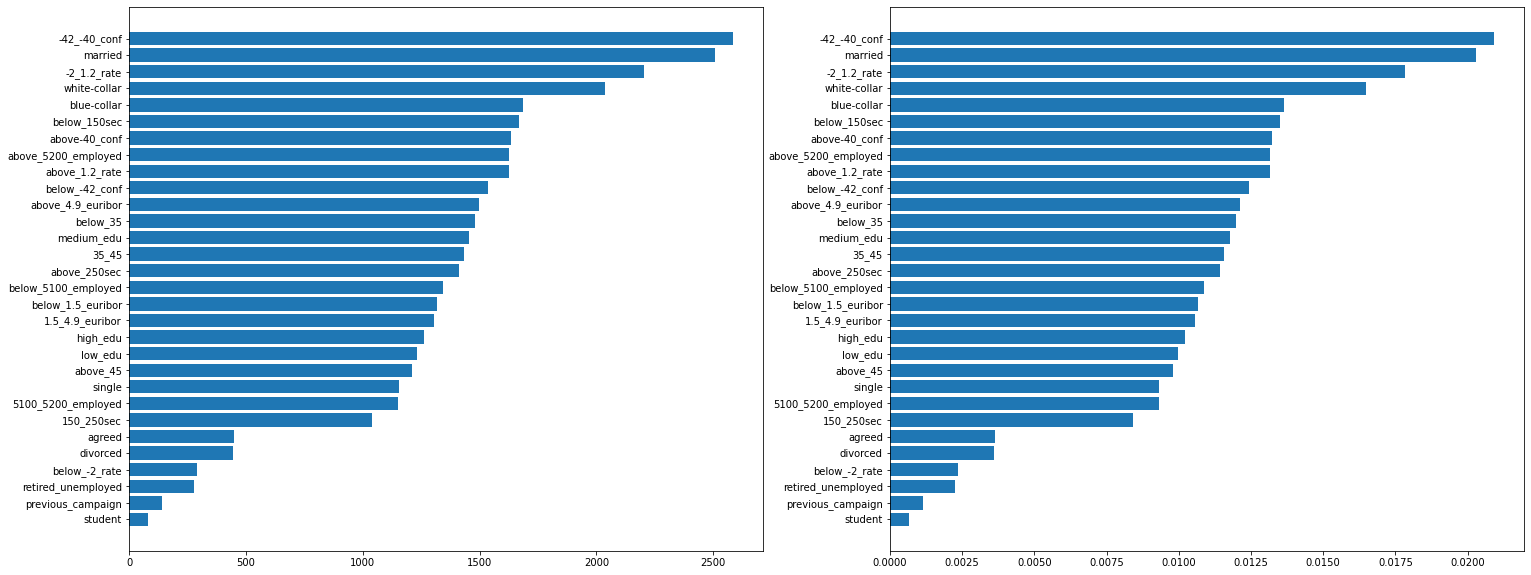

In [ ]:
# Freqeuncy
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
axes[0].barh(telemarketing.sum().sort_values().keys(),telemarketing.sum().sort_values())
axes[1].barh(telemarketing.sum().sort_values().keys(),telemarketing.sum().sort_values()/telemarketing.size)


### Before mining for association rules in this python implementation we need to calculate support for each itemset.

At first we select smalll value of min_support = 0.01 in order to start with large amount of rules and cut them down accordingly.

Just as a reminder below you can find definitions of support, confidence and lift.

Let $X$ and $Y$ be sets of characteristics then we define:

$$Support(X)=\frac{Count(X)}{N}$$

where $Count(X)$ number of obesrvations with $X$ present, $N$ all observations.


$$Confidence(X\implies Y)=\frac{Support(X\cup Y)}{Support(X)}$$

where $X\implies Y$ indicates a rule which states that for antecendent $X$ the consequent is $Y$.


$$Lift(X\implies Y)=\frac{Confidence(X\implies Y)}{Support(Y)}$$

In [9]:
frequent_itemsets = apriori(telemarketing, min_support=0.01, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.359068,(below_35)
1,0.347414,(35_45)
2,0.293518,(above_45)
3,0.409080,(blue-collar)
4,0.494295,(white-collar)
...,...,...
18039,0.011411,"(blue-collar, 5100_5200_employed, married, abo..."
18040,0.010925,"(below_150sec, white-collar, married, above_1...."
18041,0.012139,"(below_150sec, blue-collar, 5100_5200_employed..."
18042,0.013353,"(blue-collar, 5100_5200_employed, married, abo..."


### According to the common approach we are going to use confidence metric as guideline.

Again we start with low threshold to get large number of rules.

In [10]:
results = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01)

res=results[['antecedents', 'consequents', 'support','antecedent support',	'consequent support',	'support', 'confidence',	'lift']]
res

,antecedents,consequents,support,antecedent support,consequent support,support,confidence,lift
0,(below_35),(blue-collar),0.146880,0.359068,0.409080,0.146880,0.409060,0.999952
1,(blue-collar),(below_35),0.146880,0.409080,0.359068,0.146880,0.359050,0.999952
2,(below_35),(white-collar),0.181355,0.359068,0.494295,0.181355,0.505071,1.021801
3,(white-collar),(below_35),0.181355,0.494295,0.359068,0.181355,0.366896,1.021801
4,(below_35),(student),0.018694,0.359068,0.019908,0.018694,0.052062,2.615173
...,...,...,...,...,...,...,...,...
689659,(above_1.2_rate),"(below_150sec, high_edu, white-collar, married...",0.015781,0.394756,0.015781,0.015781,0.039975,2.533210
689660,(above-40_conf),"(below_150sec, high_edu, white-collar, married...",0.015781,0.396455,0.019908,0.015781,0.039804,1.999425
689661,(above_5200_employed),"(below_150sec, high_edu, white-collar, married...",0.015781,0.394756,0.015781,0.015781,0.039975,2.533210
689662,(above_4.9_euribor),"(below_150sec, high_edu, white-collar, married...",0.015781,0.363923,0.015781,0.015781,0.043362,2.747832


###We can calcualte how many rules have our dependent variable in both antecedents and consequents.

In [14]:
rhs=[]
lhs=[]
for i,k in enumerate(res['consequents']):
  if ('agreed' in k):
    rhs.append(i)
for i,k in enumerate(res['antecedents']):
  if ('agreed' in k):
    lhs.append(i)
print('number fo rules with "agreed" in the consequent set: ',len(rhs))
print('number fo rules with "agreed" in the antecedent set: ',len(lhs))

number fo rules with "agreed" in the consequent set:  10896
number fo rules with "agreed" in the antecedent set:  10896


### This is a bit overwhleming number of rules, we should try reducing it.

We can cut down number of rules by increasing min_support threshold and minimum confidence level.

In [4]:
Rs=[]
Ls=[]
for thresh in [0.01,0.02,0.03,0.04,0.05, 0.1]:

  frequent_itemsets = apriori(telemarketing, min_support=thresh, use_colnames=True)

  results = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01)
  res=results[['antecedents', 'consequents', 'support','antecedent support',	'consequent support',	'support', 'confidence',	'lift']]
  rhs=[]
  lhs=[]
  for i,k in enumerate(res['consequents']):
    if ('agreed' in k):
      rhs.append(i)
  for i,l in enumerate(res['antecedents']):
    if ('agreed' in l):
      lhs.append(i)
  Rs.append(len(rhs))
  Ls.append(len(lhs))
print('number fo rules with "agreed" in the consequent set: ', Rs)
print('number fo rules with "agreed" in the antecendent set: ', Ls)


number fo rules with "agreed" in the consequent set:  [10896, 1309, 232, 86, 42, 0]
number fo rules with "agreed" in the antecendent set:  [10896, 1309, 232, 86, 42, 0]


### As we can see the algorithm is very sensitive to the change of support value in the context of mining rules with "agreed".

let's use 0.03 as the threshold from now and check how many rules with "agreed" we can get depending on the confidence threshold.


In [6]:
frequent_itemsets = apriori(telemarketing, min_support=0.03, use_colnames=True)
Rs=[]
Ls=[]
for thresh in [0.01,0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55,0.6,0.65,0.7]:
  results = association_rules(frequent_itemsets, metric="confidence", min_threshold=thresh)
  res=results[['antecedents', 'consequents', 'support','antecedent support',	'consequent support',	'support', 'confidence',	'lift']]
  rhs=[]
  lhs=[]
  for i,k in enumerate(res['consequents']):
    if ('agreed' in k):
      rhs.append(i)
  for i,k in enumerate(res['antecedents']):
    if ('agreed' in k):
      lhs.append(i)
  Rs.append(len(rhs))
  Ls.append(len(lhs))
print('number fo rules with "agreed" in the consequent set for each threshold: ', Rs)
print('number fo rules with "agreed" in the consequent set for each threshold: ', Ls)


number fo rules with "agreed" in the consequent set for each threshold:  [232, 229, 166, 104, 82, 57, 44, 35, 30, 5, 5, 5, 5, 5, 0]
number fo rules with "agreed" in the consequent set for each threshold:  [232, 232, 232, 232, 232, 232, 223, 207, 186, 170, 148, 127, 114, 96, 70]


### For ease of visualisation we will choose threshold 0.65 which corresponds to 5 rules where 'agreed' is a part of consequent.

Firstly, we can see that overall the algorithm found almost 13 thousands rules, but only 5 of them are crucial for the predictive analysis of the telemarketing campaign.

In [7]:
frequent_itemsets = apriori(telemarketing, min_support=0.03, use_colnames=True)
results = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.65)
res=results[['antecedents', 'consequents', 'support','antecedent support',	'consequent support',	'support', 'confidence',	'lift']]
print('Number of all rules mined for thresholds 0.03 and 0.65: ',len(res))
print('\n Rules with "agreed" in consequent: ')
rhs=[]
for i,k in enumerate(res['consequents']):
  if ('agreed' in k):
    rhs.append(i)
res.iloc[rhs]

Number of all rules mined for thresholds 0.03 and 0.65:  12857

 Rules with "agreed" in consequent: 


,antecedents,consequents,support,antecedent support,consequent support,support,confidence,lift
3196,"(-42_-40_conf, below_1.5_euribor, above_250sec)",(agreed),0.03059,0.045885,0.109493,0.03059,0.666667,6.088692
3204,"(-42_-40_conf, below_5100_employed, above_250sec)",(agreed),0.03059,0.045885,0.109493,0.03059,0.666667,6.088692
8109,"(-42_-40_conf, below_1.5_euribor, below_5100_e...",(agreed),0.03059,0.045885,0.109493,0.03059,0.666667,6.088692
8110,"(-42_-40_conf, below_1.5_euribor, above_250sec)","(agreed, below_5100_employed)",0.03059,0.045885,0.076960,0.03059,0.666667,8.662461
8111,"(-42_-40_conf, below_5100_employed, above_250sec)","(below_1.5_euribor, agreed)",0.03059,0.045885,0.073804,0.03059,0.666667,9.032895


### If we allow for lower values of confidence number of rules with "agreed" as  part of consequents.

These results show more instances of more numerous sets as consequents.

In [57]:
frequent_itemsets = apriori(telemarketing, min_support=0.03, use_colnames=True)
results = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)
res=results[['antecedents', 'consequents', 'support','antecedent support',	'consequent support',	'support', 'confidence',	'lift']]
rhs=[]
for i,k in enumerate(res['consequents']):
  if ('agreed' in k):
    rhs.append(i)
res.iloc[rhs]

,antecedents,consequents,support,antecedent support,consequent support,support,confidence,lift
1944,"(above_250sec, below_1.5_euribor)",(agreed),0.050740,0.122117,0.109493,0.050740,0.415507,3.794841
1952,"(above_250sec, below_5100_employed)",(agreed),0.052197,0.124059,0.109493,0.052197,0.420744,3.842668
2109,"(-42_-40_conf, below_1.5_euribor)",(agreed),0.050740,0.115319,0.109493,0.050740,0.440000,4.018537
2125,"(-42_-40_conf, below_5100_employed)",(agreed),0.050740,0.115319,0.109493,0.050740,0.440000,4.018537
2132,"(above-40_conf, below_1.5_euribor)",(agreed),0.036902,0.084244,0.109493,0.036902,0.438040,4.000639
2143,"(above-40_conf, below_5100_employed)",(agreed),0.036902,0.084244,0.109493,0.036902,0.438040,4.000639
8927,"(-42_-40_conf, above_250sec, below_1.5_euribor)",(agreed),0.030590,0.045885,0.109493,0.030590,0.666667,6.088692
8944,"(-42_-40_conf, above_250sec, below_5100_employed)",(agreed),0.030590,0.045885,0.109493,0.030590,0.666667,6.088692
8960,"(above_250sec, below_5100_employed, below_1.5_...",(agreed),0.050740,0.122117,0.109493,0.050740,0.415507,3.794841
8964,"(above_250sec, below_5100_employed)","(agreed, below_1.5_euribor)",0.050740,0.124059,0.073804,0.050740,0.409002,5.541707


# Visualistaion

For ease of visualisation  we will use threshold 0.65 for confidence.

DISCLAIMER: This part took far to long, it's not trivial to create parallel plots in python where values are text and not numeric. For instance we cannot use pandas parralel_coordinates function. We need to make use of plotly library and customize the plot to our needs. My results could be automatised even more. 

In [5]:
# Generate list of ids where "agreed" is in the consequent
cons1=[]
for i,k in enumerate(res['consequents']):
  if ('agreed' in k):
    cons1.append(i)
print(cons1)

[3196, 3204, 8108, 8110, 8111]


In [6]:
# Function which creates coordinates for the parallel graph as a data frame
# Maximum number of elements in the antecendent is calculated automatically
def coords(rules, cons1):
  rules = rules.iloc[cons1].reset_index(drop=True)
  rows=[]
  for i in range(len(rules)):
    rows.append([k for k in rules.iloc[i][0]])
  cols = max(len(x) for x in rows)
  columns1 = [str(i+1) for i in range(cols)]
  columns2 = [str(cols-i) for i in range(cols)]
  columns1.append('id')
  columns2.append('id')
  df = pd.DataFrame(columns=columns1)
  for i,row in enumerate(rows):
    for k in range(cols):
      try:
        row[k]=row[k]
      except:
        row.append(None)
    row.append(i)
    df.loc[len(df)]=row
  
  df=df[columns2]
  df['rhs']=rules['consequents']

  return df

cords=coords(res,cons1)
cords

,4,3,2,1,id,rhs
0,None,below_1.5_euribor,above_250sec,-42_-40_conf,0,(agreed)
1,None,below_5100_employed,above_250sec,-42_-40_conf,1,(agreed)
2,below_1.5_euribor,below_5100_employed,above_250sec,-42_-40_conf,2,(agreed)
3,None,below_5100_employed,above_250sec,-42_-40_conf,3,"(agreed, below_1.5_euribor)"
4,None,below_1.5_euribor,above_250sec,-42_-40_conf,4,"(agreed, below_5100_employed)"


In [35]:
# Processing coordinates to get appropriate lists of attributes 
# Here we could also automatise generation process of value lists used in plotting
len(cords['1'].unique()), len(cords['2'].unique()), len(cords['3'].unique()), len(cords['4'].unique())
s1=set(cords['1'])
s2=set(cords['2'])
s3=set(cords['3'])
s4=set(cords['4'])
attributes = list(s1 | s2 | s3 | s4)
len(attributes)
rhs = list(cords['rhs'])
rhs =', '.join(('below_1.5_euribor', 'agreed'))
rhs = [', '.join(('below_1.5_euribor', 'agreed')), ', '.join(('below_5100_employed', 'agreed')),' ','agreed']
attributes[0]=str(attributes[0])
attributes

['None',
 'above_250sec',
 'below_5100_employed',
 'below_1.5_euribor',
 '-42_-40_conf']

## At last we produce a parallel coordinate plot of all five rules.

We could also display 30 rules with minimum threshold 0.4 but this would be even more time consuming and would have marginal effecto on grading :)

Nevertheless, if one of the students would need this type of visualisation feel free to share this code.

In [54]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line_color=cords['id'],
        dimensions = list([
            dict(range = [1,5],
                tickvals = list(range(1,len(attributes)+1)),
                 constraintrange = [1,5], # change this range by dragging the pink line
                 label = '1st ant.', values = [1,1,5,1,1],
                 ticktext = attributes),
            dict(range = [1,5],
                tickvals = list(range(1,len(attributes)+1)),
                 constraintrange = [-1,15], # change this range by dragging the pink line
                 label = '2nd ant.', values = [2,3,4,3,2],
                 ticktext = attributes),
            dict(range = [1,5],
                tickvals = list(range(1,len(attributes)+1)),
                 constraintrange = [-1,15], # change this range by dragging the pink line
                 label = '3rd ant.', values = [4,2,3,4,5],
                 ticktext = attributes),
            dict(range = [1,5],
                tickvals = list(range(1,len(attributes)+1)),
                 constraintrange = [-1,15], # change this range by dragging the pink line
                 label = '4th ant.', values = [5,5,2,2,4],
                 ticktext = attributes),
            dict(range = [1,5],
                 tickvals = list(range(1,len(attributes)+1)),
                 constraintrange = [-1,15], 
                 label = 'rhs', values = [4,4,4,1,2],
                 ticktext = rhs)
        ])
    )
)
fig.show()

# Summary

This analysis shows that association rules mining can be used in the field of telemarketing and specificly banking industry. Results are not astonishing, but can generate rules for prioritising clients which are more potent to new campaigns. 

It is worth noting that in this case none of the metrics susch as age or martial status where important. 

Ancendents mostly consit of number of employees and macroeconomic variables such as inflation or euribor3m.